In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,8

In [3]:
data=pd.read_csv('/content/time_series.csv')

In [4]:
data=data.dropna()

In [5]:
data

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0
...,...,...
100,1972-05,4618.0
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0


i have to change the column name

In [6]:
data['Month']=pd.to_datetime(data['Month'])

In [7]:
data.rename(columns={'Perrin Freres monthly champagne sales millions ?64-?72':'sales'},inplace=True)

Lets set the index by month

In [8]:
data.set_index('Month',inplace=True)

In [9]:
data

,sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
...,...
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0


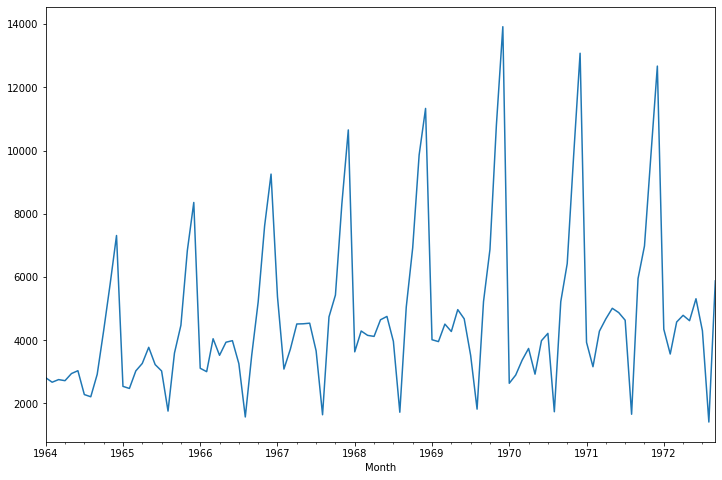

In [10]:
data['sales'].plot()

It does not look like stationary lets so test and see


In [11]:
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [12]:
def adfuller_test(sales):
  results=adfuller(sales)
  labels=['ADF test statistics','p-value','lags used','no.of observation used']
  for value,label in zip(results,labels):
    print(label + ' : '+ str(value))

In [13]:
adfuller_test(data['sales'])

ADF test statistics : -1.8335930563276226
p-value : 0.3639157716602452
lags used : 11
no.of observation used : 93


As we can see p value is less then 0.05 so i was right it is not stationary

Lets make it Stationary

In [14]:
data['seasonal_difference']=data['sales'] - data['sales'].shift(12)

In [15]:
adfuller_test(data['seasonal_difference'].dropna())

ADF test statistics : -7.626619157213164
p-value : 2.060579696813685e-11
lags used : 0
no.of observation used : 92


Now my p value is good as compare to before

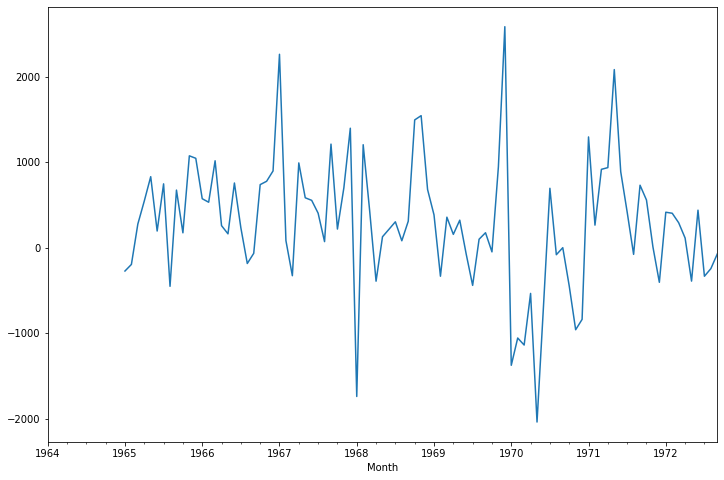

In [16]:
data['seasonal_difference'].plot()

In [17]:
from pandas.plotting import autocorrelation_plot

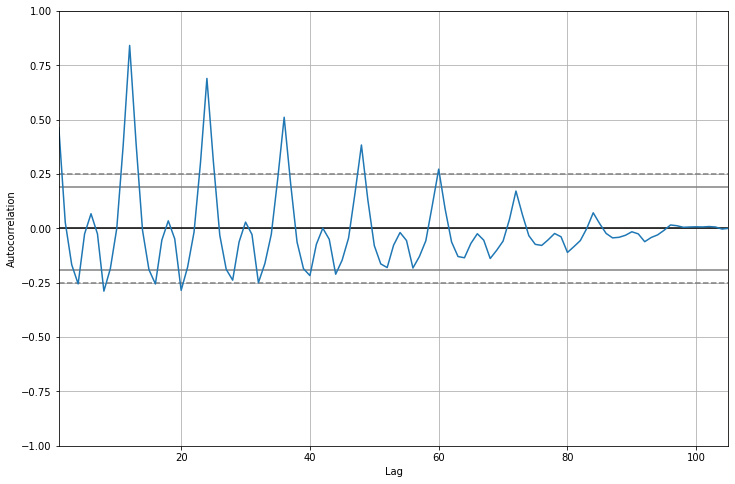

In [18]:
autocorrelation_plot(data['sales'])

Now i have to find p and q value so i will plot acf and pacf graph

In [19]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

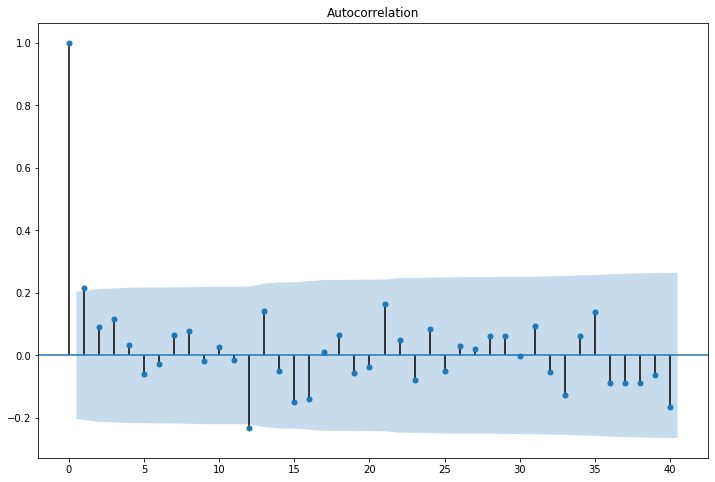

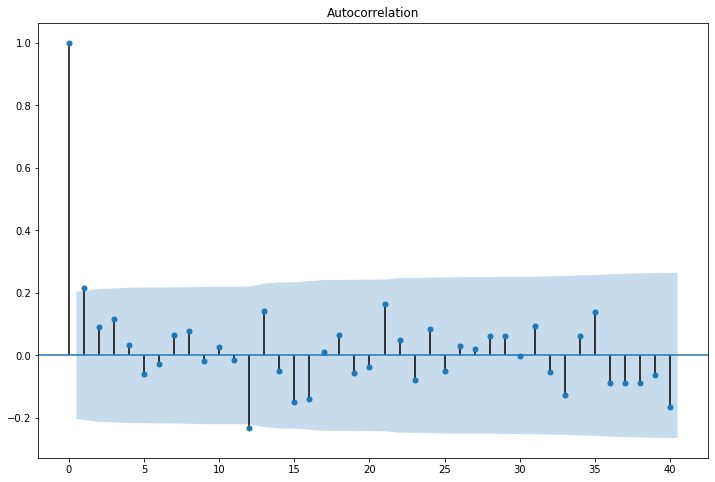

In [20]:
plot_acf(data['seasonal_difference'].dropna(),lags=40)

So p value will be 1 because at 1 there is a shut-off

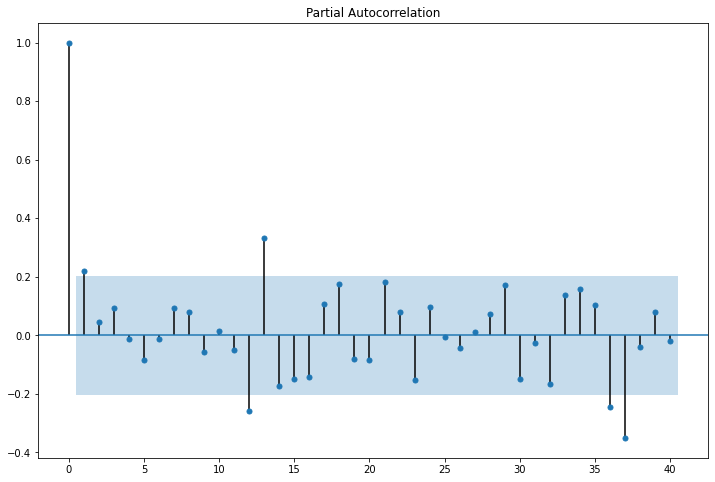

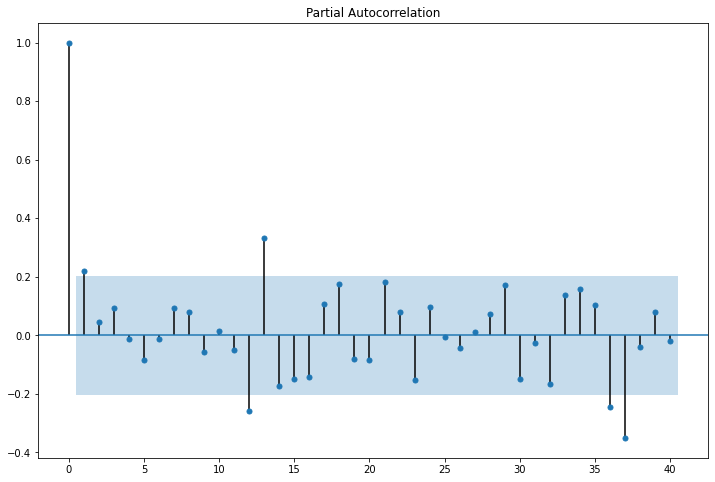

In [21]:
plot_pacf(data['seasonal_difference'].dropna(),lags=40)

q value will also be 1

Now my data is seasonal so i will use SARIMAX if my data was not seasonal i will be using ARIMAX

In [22]:
import statsmodels.api as sm

In [23]:
model=sm.tsa.statespace.SARIMAX(data['sales'],order=(1,1,1),seasonal_order=(1,1,1,12))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [24]:
result=model.fit()

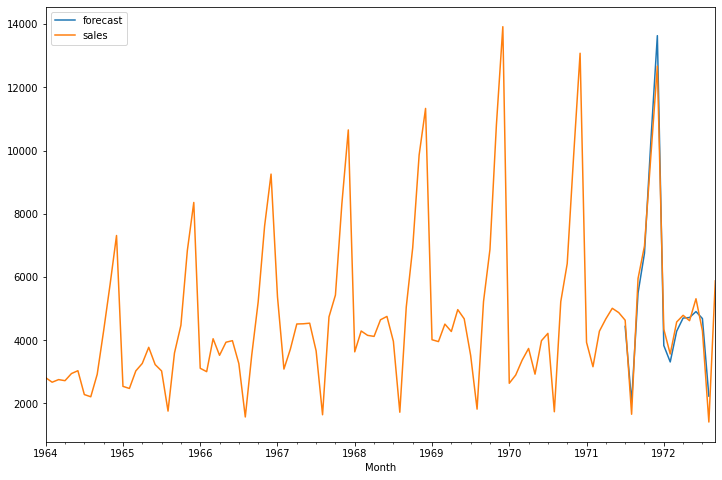

In [25]:
data['forecast']=result.predict(start=90,end=103,dynamic=True)
data[['forecast','sales']].plot()

In [26]:
from pandas.tseries.offsets import DateOffset

In [27]:
future_dates=[data.index[-1]+DateOffset(months=x) for x in range(0,24)]

In [28]:
future_dates_df=pd.DataFrame(index=future_dates[1:],columns=data.columns)

In [29]:
future_df=pd.concat([data,future_dates_df])

In [30]:
future_df.shape

(128, 3)

In [31]:
future_df['forecast']=result.predict(start=104,end=120)

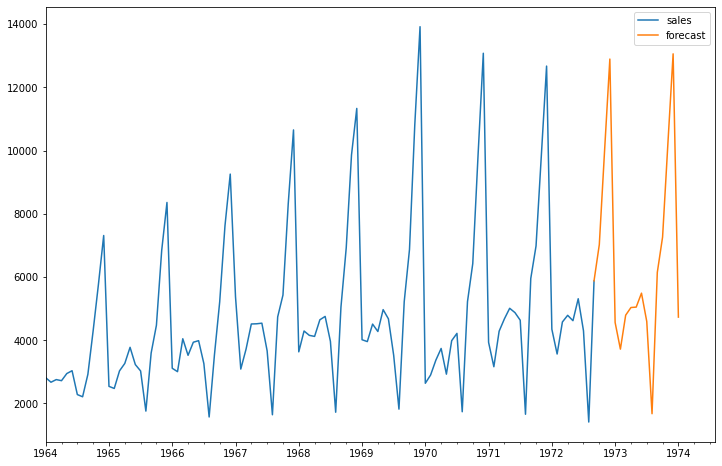

In [32]:
future_df[['sales','forecast']].plot()

#The blue line is for real time and orange line is forecasted line its look perfect